In [1]:
import os
os.chdir("/content/drive/MyDrive/Audio Analysis with Librosa")

In [3]:
!pip install gradio

     |████████████████████████████████| 649 kB 5.0 MB/s 
     |████████████████████████████████| 210 kB 33.1 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 255 kB 32.3 MB/s 
     |████████████████████████████████| 1.1 MB 26.8 MB/s 
     |████████████████████████████████| 2.0 MB 25.4 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 271 kB 34.2 MB/s 
     |████████████████████████████████| 144 kB 33.4 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 10.9 MB 29.8 MB/s 
     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 856 kB 28.4 MB/s 
     |████████████████████████████████| 3.6 MB 31.4 MB/s 
     |██████████████████████

In [4]:
# %downloading datasets from kaggle

# %install kagggle library
! pip install kaggle --upgrade

# %creating .kaggle dir
! mkdir ~/.kaggle

# %Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/kaggle.json

# %allocating permission .kaggle dir
! chmod 600 ~/.kaggle/kaggle.json

# %downloading datasets from kaggle
! kaggle datasets download -d mmoreaux/audio-cats-and-dogs

audio-cats-and-dogs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# %since downloaded dataset are zipped we should consider extracting zip file
! unzip audio-cats-and-dogs.zip

Archive:  audio-cats-and-dogs.zip
  inflating: cats_dogs/cat_1.wav     
  inflating: cats_dogs/cat_10.wav    
  inflating: cats_dogs/cat_100.wav   
  inflating: cats_dogs/cat_101.wav   
  inflating: cats_dogs/cat_102.wav   
  inflating: cats_dogs/cat_103.wav   
  inflating: cats_dogs/cat_105.wav   
  inflating: cats_dogs/cat_106.wav   
  inflating: cats_dogs/cat_107.wav   
  inflating: cats_dogs/cat_108.wav   
  inflating: cats_dogs/cat_109.wav   
  inflating: cats_dogs/cat_11.wav    
  inflating: cats_dogs/cat_110.wav   
  inflating: cats_dogs/cat_112.wav   
  inflating: cats_dogs/cat_113.wav   
  inflating: cats_dogs/cat_114.wav   
  inflating: cats_dogs/cat_115.wav   
  inflating: cats_dogs/cat_116.wav   
  inflating: cats_dogs/cat_117.wav   
  inflating: cats_dogs/cat_118.wav   
  inflating: cats_dogs/cat_119.wav   
  inflating: cats_dogs/cat_12.wav    
  inflating: cats_dogs/cat_120.wav   
  inflating: cats_dogs/cat_121.wav   
  inflating: cats_dogs/cat_122.wav   
  inflating: cat

In [60]:
# import library
import gradio as gr
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.0


In [61]:
# %loading data
df = pd.read_csv("train_test_split.csv")

df.head()

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


In [62]:
# %setting train and test path
dog_train_path = "cats_dogs/train/dog/"
dog_test_path = "cats_dogs/test/test/"

cat_train_path = "cats_dogs/train/cat/"
cat_test_path = "cats_dogs/test/cats/"

train_cat_fnames=os.listdir(cat_train_path)
train_cat_fnames[:5]

['cat_106.wav', 'cat_138.wav', 'cat_142.wav', 'cat_121.wav', 'cat_113.wav']

In [63]:
# %assigning lables to train and test files
test_cat = df[['test_cat']].dropna().rename(index=str, columns={"test_cat": "file"}).assign(label=0)
test_dog = df[['test_dog']].dropna().rename(index=str, columns={"test_dog": "file"}).assign(label=1)
train_cat = df[['train_cat']].dropna().rename(index=str, columns={"train_cat": "file"}).assign(label=0)
train_dog = df[['train_dog']].dropna().rename(index=str, columns={"train_dog": "file"}).assign(label=1)

test_df = pd.concat([test_cat, test_dog]).reset_index(drop=True)
train_df = pd.concat([train_cat, train_dog]).reset_index(drop=True)

train_df.head(10)

,file,label
0,cat_99.wav,0
1,cat_54.wav,0
2,cat_34.wav,0
3,cat_132.wav,0
4,cat_124.wav,0
5,cat_56.wav,0
6,cat_86.wav,0
7,cat_119.wav,0
8,cat_134.wav,0
9,cat_130.wav,0


In [64]:
# %inspecting train data
train_df.tail(10)


,file,label
169,dog_barking_87.wav,1
170,dog_barking_12.wav,1
171,dog_barking_19.wav,1
172,dog_barking_49.wav,1
173,dog_barking_81.wav,1
174,dog_barking_9.wav,1
175,dog_barking_111.wav,1
176,dog_barking_67.wav,1
177,dog_barking_108.wav,1
178,dog_barking_41.wav,1


In [65]:
# %load cat audio file
path_c=os.path.join(cat_train_path, df['train_cat'].loc[80])

In [66]:
# %Let's hear cat audio
import IPython.display as ipd
ipd.Audio(path_c)

In [67]:
# %load dog audio file
path_d=os.path.join(dog_train_path, df['train_dog'].loc[4])
ipd.Audio(path_d)

In [68]:
# %loading cat audio with librosa
data_c, sampling_rate_c = librosa.load(path_c,sr=None)

**WAVEFORM REPRESENTATION**

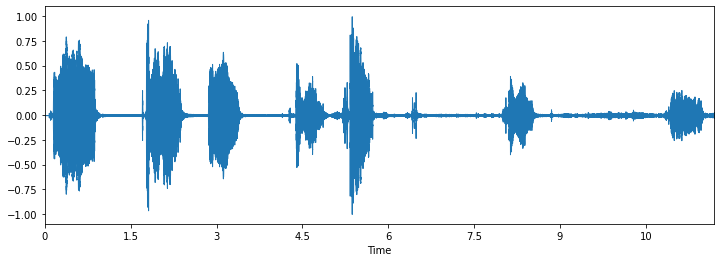

In [69]:
import librosa.display

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data_c, sr=sampling_rate_c)
plt.show()

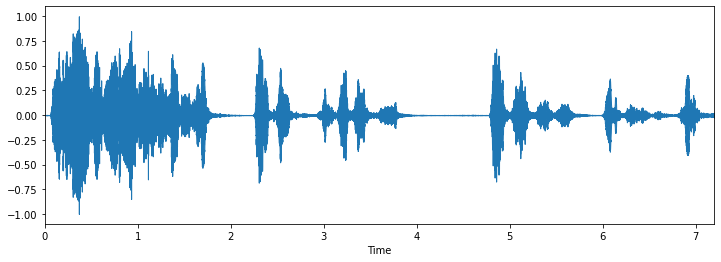

In [70]:

# %loading dog audio with librosa
data_d, sampling_rate_d = librosa.load(path_d,sr=None)

# %waveform represenation for dog audio
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data_d, sr=sampling_rate_d)
plt.show()

**SPECTROGRAM REPRESENTATION**

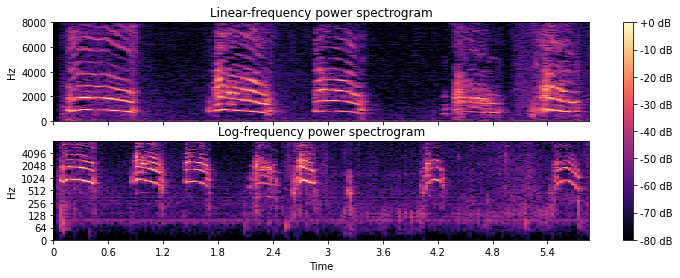

In [71]:
# % spectrogram for cat waveform
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 4))

D = librosa.amplitude_to_db(np.abs(librosa.stft(data_c)), ref=np.max)
img=librosa.display.specshow(D, sr=sampling_rate_c, x_axis='time', y_axis='hz', ax=ax[0])
ax[0].set_title('Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(data_c, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate_c, x_axis='time', y_axis='log', ax=ax[1])
ax[1].set_title('Log-frequency power spectrogram')
ax[1].label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB");

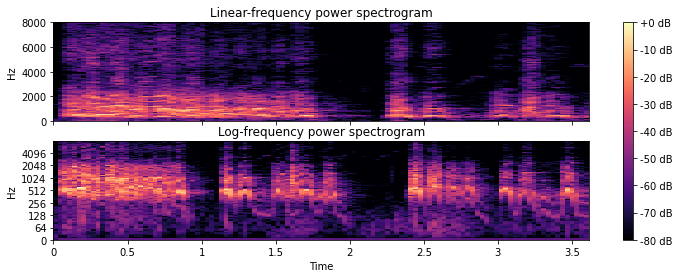

In [72]:
# % spectrogram for dog waveform
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 4))

D = librosa.amplitude_to_db(np.abs(librosa.stft(data_d)), ref=np.max)
img=librosa.display.specshow(D, sr=sampling_rate_d, x_axis='time', y_axis='hz', ax=ax[0])
ax[0].set_title('Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(data_d, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate_d, x_axis='time', y_axis='log', ax=ax[1])
ax[1].set_title('Log-frequency power spectrogram')
ax[1].label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB");

**PROCESSING**

In [186]:
# %setting train and test data path
train_dir='cats_dogs/train'
test_dir='cats_dogs/test'

file_train = tf.io.gfile.glob(train_dir + '/*/*')
file_train = tf.random.shuffle(file_train)
train_ds=file_train[:168]
val_ds = file_train[168:168+42]

file_test = tf.io.gfile.glob(test_dir + '/*/*')
file_test = tf.random.shuffle(file_test)
test_ds=file_test

In [187]:
train_ds.shape , val_ds.shape,test_ds.shape

(TensorShape([168]), TensorShape([42]), TensorShape([67]))

In [188]:
def get_waveform_label(file):
    lab = tf.strings.split(file, os.path.sep)[-2]
    audio_binary = tf.io.read_file(file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform=tf.squeeze(audio, axis=-1)
    return waveform, lab

AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

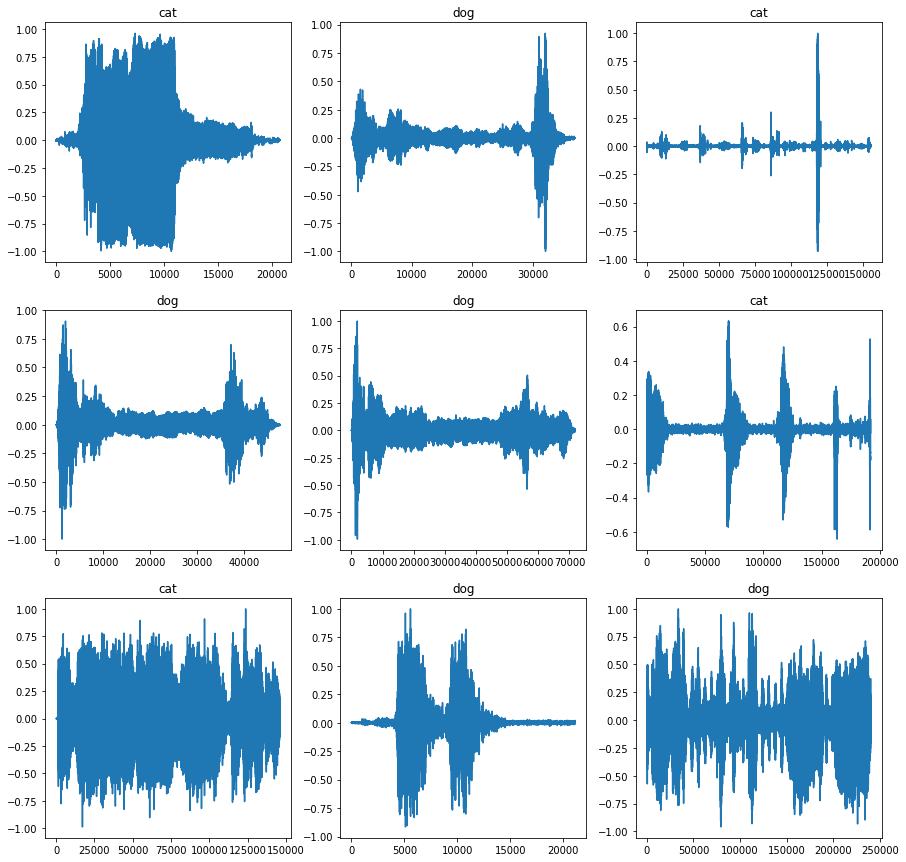

In [189]:
fig, axs = plt.subplots(3,3,figsize=(15,15))

for i, (audio,label) in enumerate(waveform_ds.take(3*3)):
    r = i//3
    c = i%3
    ax = axs[r][c]
    ax.plot(audio.numpy())
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

In [190]:
def get_spectrogram_label(audio, label):
    padding = tf.zeros([300000]-tf.shape(audio), dtype=tf.float32)
    wave = tf.cast(audio, tf.float32)
    eq_length = tf.concat([wave, padding], 0)
    spectrogram = tf.signal.stft(eq_length, frame_length=210, frame_step=110)    
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == labels)
    return spectrogram, label_id

Name=["cat", "dog", "test"]
labels = np.array(Name)
spectrogram_ds = waveform_ds.map(get_spectrogram_label, num_parallel_calls=AUTO)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


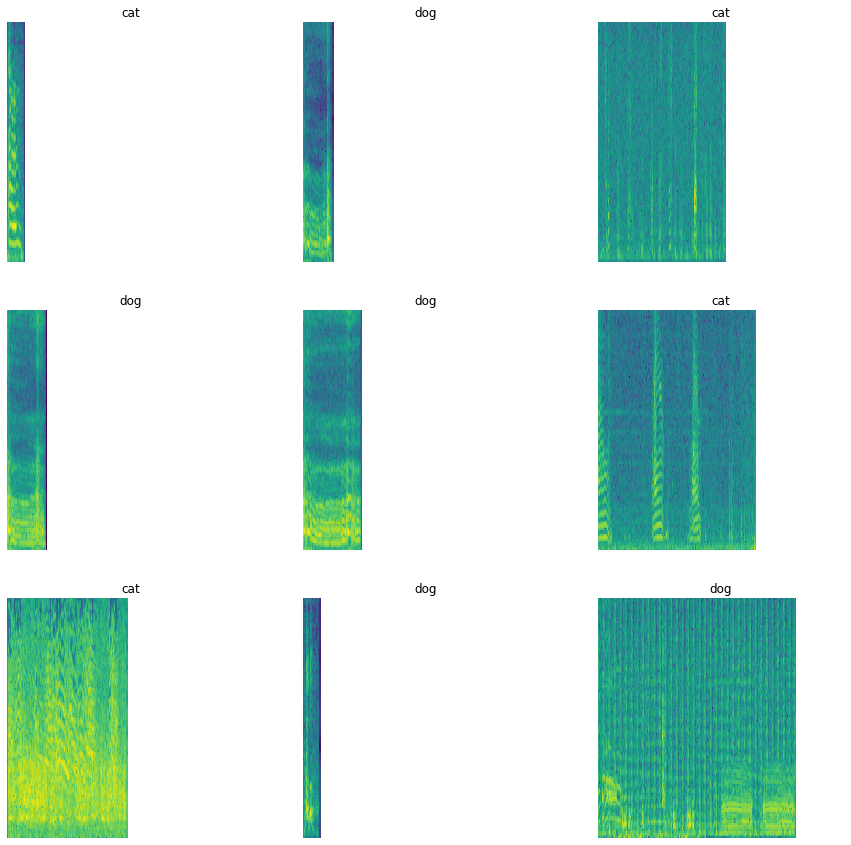

In [191]:
def plot_spect(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(3,3, figsize=(15,15))

for i, (spectrogram,label_id) in enumerate(spectrogram_ds.take(3*3)):
    r = i//3
    c = i%3
    ax = axes[r][c]
    plot_spect(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(labels[label_id.numpy()])
    ax.axis('off')

In [192]:
def preprocess(file):
    files_ds = tf.data.Dataset.from_tensor_slices(file)
    output_ds = files_ds.map(get_waveform_label,num_parallel_calls=AUTO)
    output_ds = output_ds.map(get_spectrogram_label,num_parallel_calls=AUTO)
    return output_ds

train_ds = spectrogram_ds
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTO)
val_ds = val_ds.cache().prefetch(AUTO)

In [193]:
for spectrogram,_ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

num_labels = len(labels)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

print(input_shape)
print(num_labels)

(2726, 129, 1)
3


**MODELING**

In [194]:
model = Sequential([
   Input(shape=input_shape), preprocessing.Resizing(32, 32), norm_layer,
   Conv2D(32,3, activation='relu'),
   Conv2D(64,3, activation='relu'),
   MaxPool2D(),
   Dropout(0.5),
   Conv2D(128,7, activation='relu'),
   Conv2D(256,7, activation='relu'),
   MaxPool2D(),
   Dropout(0.5),
   Flatten(),
   Dense(128, activation='relu'),
   Dropout(0.2),
   Dense(16, activation='relu'),
   Dense(num_labels),
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_4 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)       

In [195]:
his = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
3/3 [==============================] - 10s 3s/step - loss: 3.7435 - accuracy: 0.5119 - val_loss: 2.2257 - val_accuracy: 0.7381
Epoch 2/25
3/3 [==============================] - 0s 75ms/step - loss: 2.0512 - accuracy: 0.3810 - val_loss: 0.5860 - val_accuracy: 0.0000e+00
Epoch 3/25
3/3 [==============================] - 0s 82ms/step - loss: 1.1551 - accuracy: 0.3869 - val_loss: 0.5252 - val_accuracy: 0.0000e+00
Epoch 4/25
3/3 [==============================] - 0s 81ms/step - loss: 0.8572 - accuracy: 0.2976 - val_loss: 0.4990 - val_accuracy: 0.0000e+00
Epoch 5/25
3/3 [==============================] - 0s 77ms/step - loss: 0.8606 - accuracy: 0.2262 - val_loss: 0.4897 - val_accuracy: 0.1429
Epoch 6/25
3/3 [==============================] - 0s 75ms/step - loss: 0.7226 - accuracy: 0.3452 - val_loss: 0.5010 - val_accuracy: 0.2619
Epoch 7/25
3/3 [==============================] - 0s 83ms/step - loss: 0.7095 - accuracy: 0.4583 - val_loss: 0.4844 - val_accuracy: 0.2619
Epoch 8/25
3/3 [

**EVALUATION**

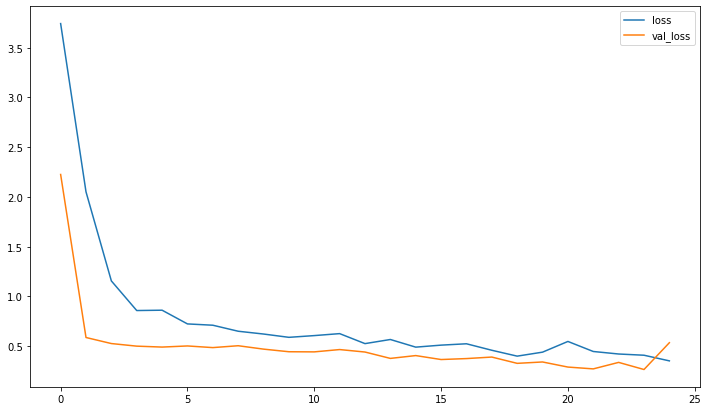

In [196]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(his.epoch, his.history['loss'], his.history['val_loss'])
plt.legend(['loss', 'val_loss']);

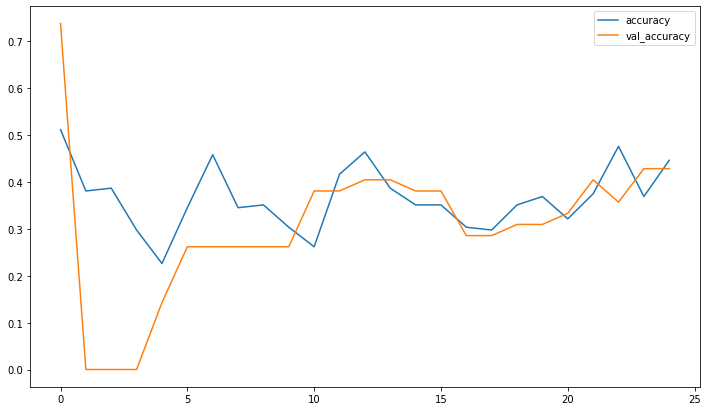

In [197]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(his.epoch, his.history['accuracy'], his.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy']);

In [198]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
test_labels

array([0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0,
       2])

In [199]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
print(y_pred)

t_labels=[]
pred_labels=[]

for item in test_labels:
    if item == 2:
        t_labels+=[1]
    else:
        t_labels+=[0]
        
for item in y_pred:
    if item == 2:
        pred_labels+=[1]
    else:
        pred_labels+=[item]

y_true = np.array(t_labels)

y_pred = np.array(pred_labels)
print(y_pred)

[1 2 0 1 1 2 1 2 1 1 1 2 1 1 2 2 0 1 0 2 1 0 1 0 1 1 1 0 0 0 1 2 1 2 1 2 2
 0 0 2 1 1 1 1 1 0 1 1 0 1 2 1 1 1 2 2 2 0 1 1 2 1 2 1 1 1 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


In [200]:
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 58%


In [201]:
from sklearn.metrics import classification_report, log_loss, accuracy_score

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.31      0.46        39
           1       0.50      0.96      0.66        28

    accuracy                           0.58        67
   macro avg       0.71      0.64      0.56        67
weighted avg       0.75      0.58      0.54        67



**TESTING SINGLE INPUT**

In [202]:
file_path = 'cats_dogs/dog_barking_102.wav'

In [203]:
def get_waveform_label(file):
    lab = tf.strings.split(file, os.path.sep)[-2]
    audio_binary = tf.io.read_file(file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform=tf.squeeze(audio, axis=-1)
    return waveform

# rr = get_waveform_label(file_path)

In [204]:
def get_spectrogram_label(audio):
    padding = tf.zeros([300000]-tf.shape(audio), dtype=tf.float32)
    wave = tf.cast(audio, tf.float32)
    eq_length = tf.concat([wave, padding], 0)
    spectrogram = tf.signal.stft(eq_length, frame_length=210, frame_step=110)    
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram

# rr_spec = get_spectrogram_label(rr)

In [205]:
def get_audio(audio):
  audio_waveform = get_waveform_label(audio)
  audio_spect = get_spectrogram_label(audio_waveform)
  final_feat = np.array([audio_spect])
  res = np.argmax(model.predict(final_feat),axis=1)
  if res == 1:
    res ="Dog Audio";
  else:
    res = "Cat Audio"
  return res

In [206]:
# [0] is cat & [1] is dog
get_audio(file_path)

'Dog Audio'

In [207]:
iface = gr.Interface(fn=get_audio,inputs=["audio", "audio"],title="CAT_DOG AUDIO CLASSIFICATION",outputs="html").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://33120.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
